# Data Load


In [1]:
import numpy as np
import pandas as pd

In [2]:
path = "./Dataset/"

data = pd.read_csv(path+"kwproja_data.csv")

data

,date,shop_code,shop_name,shop_type_big,shop_type_small,longitude,latitude,monthly_gain,average_sale_price,female_20,...,weekday4,weekday5,weekday6,time_05_10,time_10_14,time_14_18,time_18_20,time_20_22,time_22_24,time_00_05
0,201703,95662180105,닥터빈스,음식,카페 일반,126.927911,37.558043,5.696400e+06,9982,9.58,...,17.15,11.92,6.34,1.15,72.78,23.14,2.93,0.00,0.00,0.00
1,201703,1140530114,전주식당,음식,한정식/백반 전문점,127.022532,37.506856,8.496120e+06,14503,5.08,...,19.38,16.35,10.82,0.83,76.82,13.25,9.09,0.00,0.00,0.00
2,201703,43562400602,삼육가,음식,고기구이 전문점,127.025013,37.505696,1.036515e+08,72527,10.51,...,21.18,21.59,18.04,4.64,8.50,2.40,18.67,50.05,9.84,5.89
3,201702,43562400602,삼육가,음식,고기구이 전문점,127.025013,37.505696,9.678575e+07,70225,12.10,...,26.08,22.60,15.51,2.68,8.09,5.77,10.15,54.61,16.25,2.45
4,201702,88958530107,아디다스퍼포먼스타임스퀘어,소매,스포츠용품 판매,126.903306,37.517063,1.266359e+08,91884,15.04,...,16.44,10.38,22.71,0.43,26.38,39.20,25.30,8.69,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153390,201801,45688770211,(주)스위틀,학문/교육,학원-기타,127.040033,37.525081,2.277527e+07,1114250,0.00,...,26.48,0.00,0.00,73.52,26.48,0.00,0.00,0.00,0.00,0.00
153391,201712,65130960211,젤 에스테틱,소매,화장품 판매,127.046604,37.524470,1.555300e+06,33556,0.00,...,5.30,23.18,20.53,23.18,52.65,13.58,10.60,0.00,0.00,0.00
153392,201712,708600354,카카오아이엑스 주식회사,소매,장난감/오락기기/용품 판매,127.060835,37.509203,3.134106e+08,39543,31.27,...,13.02,13.71,13.84,6.60,44.94,36.45,12.01,0.00,0.00,0.00
153393,201712,51363910128,월드타워약국,의료,약국,127.103491,37.513101,7.927725e+07,9874,23.15,...,10.42,11.71,16.84,4.45,25.70,30.00,22.70,16.61,0.55,0.00


# EDA

153395 rows X 31 columns

- longtitude : 경도, latitude : 위도 
- weekday0~6 : 일 ~ 월
- time -> 05_10 / 10_14 / 14_18 / 18_20 / 20_22 / 22_24 / 24_05 => 시간대가 동일하지 않음
- female/male : 20/30/40/50 -> 8 columns
- shop_type_big -> 14 category
- shop_type_small -> 367 category
- date -> 12 category, 201702~ 201801 까지의 data
- shop_code -> 식별자 feature, input feature로는 사용하지 않지만 분류를 위해서는 사용할 수 있을 것 같음  
- shop_name -> input feature로는 사용하지 않음 
- monthly_gain / avearge_sale_price = 한달 총 판매수

##### monthly_gain과 average_sale_price 중 어느 것을 y값으로 둘 것인가? : y_label 비교해보아야 할 것 같음 
##### shop_code와 관련해서 input feature에 분류해서 넣어야 하는가? 상관없는가? 

In [3]:
data.head()

,date,shop_code,shop_name,shop_type_big,shop_type_small,longitude,latitude,monthly_gain,average_sale_price,female_20,...,weekday4,weekday5,weekday6,time_05_10,time_10_14,time_14_18,time_18_20,time_20_22,time_22_24,time_00_05
0,201703,95662180105,닥터빈스,음식,카페 일반,126.927911,37.558043,5696400.0,9982,9.58,...,17.15,11.92,6.34,1.15,72.78,23.14,2.93,0.00,0.00,0.00
1,201703,1140530114,전주식당,음식,한정식/백반 전문점,127.022532,37.506856,8496120.0,14503,5.08,...,19.38,16.35,10.82,0.83,76.82,13.25,9.09,0.00,0.00,0.00
2,201703,43562400602,삼육가,음식,고기구이 전문점,127.025013,37.505696,103651502.5,72527,10.51,...,21.18,21.59,18.04,4.64,8.50,2.40,18.67,50.05,9.84,5.89
3,201702,43562400602,삼육가,음식,고기구이 전문점,127.025013,37.505696,96785751.0,70225,12.10,...,26.08,22.60,15.51,2.68,8.09,5.77,10.15,54.61,16.25,2.45
4,201702,88958530107,아디다스퍼포먼스타임스퀘어,소매,스포츠용품 판매,126.903306,37.517063,126635883.6,91884,15.04,...,16.44,10.38,22.71,0.43,26.38,39.20,25.30,8.69,0.00,0.00


In [4]:
data.columns

Index(['date', 'shop_code', 'shop_name', 'shop_type_big', 'shop_type_small',
       'longitude', 'latitude', 'monthly_gain', 'average_sale_price',
       'female_20', 'female_30', 'female_40', 'female_50', 'male_20',
       'male_30', 'male_40', 'male_50', 'weekday0', 'weekday1', 'weekday2',
       'weekday3', 'weekday4', 'weekday5', 'weekday6', 'time_05_10',
       'time_10_14', 'time_14_18', 'time_18_20', 'time_20_22', 'time_22_24',
       'time_00_05'],
      dtype='object')

In [5]:
data.dtypes

date                    int64
shop_code               int64
shop_name              object
shop_type_big          object
shop_type_small        object
longitude             float64
latitude              float64
monthly_gain          float64
average_sale_price      int64
female_20             float64
female_30             float64
female_40             float64
female_50             float64
male_20               float64
male_30               float64
male_40               float64
male_50               float64
weekday0              float64
weekday1              float64
weekday2              float64
weekday3              float64
weekday4              float64
weekday5              float64
weekday6              float64
time_05_10            float64
time_10_14            float64
time_14_18            float64
time_18_20            float64
time_20_22            float64
time_22_24            float64
time_00_05            float64
dtype: object

In [6]:
# 13633 
# 13352
# shop_name과 shop_code가 항상 같다면, 위 두 숫자가 같아야 하는데 약 300개의 data가 차이가 남 
# shop_code는 동일하지만(가게는 동일하지만) 업종, 가게명이 바뀌었을 수도 있음 -> shop_code를 식별자 feature로 사용
print(data['shop_name'].nunique())
print(data['shop_code'].nunique())
print(data['longitude'].nunique())
print(data['latitude'].nunique())
print(data['shop_type_big'].nunique())
print(data['shop_type_small'].nunique())
print(data['date'].unique())

13633
13352
3845
3845
14
367
[201703 201702 201705 201704 201707 201706 201709 201708 201711 201710
 201712 201801]


In [18]:
# shop_code는 동일하지만 shop_name이 바뀌는 것을 확인
# 보통은 13(12)개의 data가 있는 반면 이렇게 name이 바뀌는 경우 row data 수가 36개까지 증가하는 것으로 보임
data[data['shop_code'] == 68608110104]

,date,shop_code,shop_name,shop_type_big,shop_type_small,longitude,latitude,monthly_gain,average_sale_price,female_20,...,weekday4,weekday5,weekday6,time_05_10,time_10_14,time_14_18,time_18_20,time_20_22,time_22_24,time_00_05
6709,201703,68608110104,(주)하이마트압구정지점,소매,가전제품 소매,127.027419,37.519889,2.586974e+09,789325,3.83,...,22.44,9.67,18.95,1.75,35.07,29.77,22.19,11.22,0.00,0.0
6832,201702,68608110104,(주)하이마트압구정지점,소매,가전제품 소매,127.027419,37.519889,1.548152e+09,594177,3.71,...,12.88,8.24,22.15,4.14,30.93,34.10,25.06,5.77,0.00,0.0
11483,201703,68608110104,롯데하이마트(주)잠실지점,소매,가전제품 소매,127.098024,37.511472,3.243138e+09,314498,5.42,...,9.18,12.09,23.49,2.59,30.16,34.46,18.63,14.01,0.16,0.0
11591,201702,68608110104,롯데하이마트(주)잠실지점,소매,가전제품 소매,127.098024,37.511472,2.998128e+09,322712,5.52,...,8.96,12.76,20.97,1.49,30.42,33.34,22.97,9.36,2.42,0.0
23312,201703,68608110104,롯데하이마트(주)월드타워지점,소매,가전제품 소매,127.103491,37.513101,3.131850e+09,364162,11.29,...,5.85,15.98,21.23,0.51,22.39,39.45,16.85,19.77,1.04,0.0
23313,201702,68608110104,롯데하이마트(주)월드타워지점,소매,가전제품 소매,127.103491,37.513101,2.851156e+09,341876,11.77,...,8.31,10.95,21.98,0.88,23.16,40.85,22.08,12.89,0.15,0.0
30639,201704,68608110104,(주)하이마트압구정지점,소매,가전제품 소매,127.027419,37.519889,1.784357e+09,709565,1.64,...,8.85,7.31,14.67,1.02,34.19,35.55,20.54,8.70,0.00,0.0
34731,201705,68608110104,(주)하이마트압구정지점,소매,가전제품 소매,127.027419,37.519889,1.933278e+09,679373,5.74,...,18.52,14.90,9.66,1.14,28.82,37.07,20.32,12.65,0.00,0.0
35480,201705,68608110104,롯데하이마트(주)잠실지점,소매,가전제품 소매,127.098024,37.511472,2.730470e+09,315031,5.14,...,10.68,13.66,22.10,1.46,27.48,31.25,24.88,14.90,0.04,0.0
35530,201704,68608110104,롯데하이마트(주)잠실지점,소매,가전제품 소매,127.098024,37.511472,2.641395e+09,319231,6.83,...,6.76,14.99,19.28,2.43,26.85,30.62,27.84,12.00,0.26,0.0


In [28]:
data['monthly_gain'].value_counts()

0.000000e+00    3605
5.010000e+05      57
2.555000e+05      54
5.070000e+05      54
1.521000e+05      48
                ... 
1.076660e+06       1
1.539399e+08       1
2.108208e+06       1
2.986822e+06       1
2.293351e+09       1
Name: monthly_gain, Length: 114882, dtype: int64

## Graph

In [8]:
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib import rc
%matplotlib inline
plt.rcParams['axes.unicode_minus'] = False
font_path = "C:/Windows/Fonts/NGULIM.TTF"
font = fm.FontProperties(fname=font_path).get_name()
rc('font', family=font)


In [9]:
def view_price_hist(label) : 
    plt.hist(data[label])
    plt.title('price hist')
    plt.show()

def view_price_graph(label) :
    plt.subplot(211)
    plt.plot(data[label])
    plt.show()

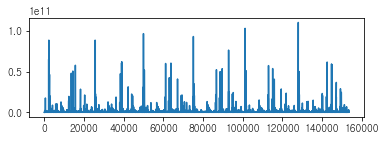

In [10]:
view_price_graph('monthly_gain')

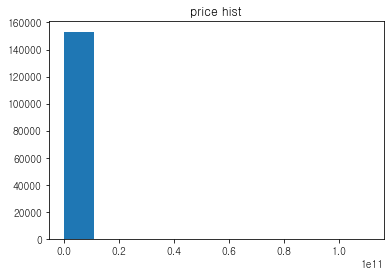

In [11]:
view_price_hist('monthly_gain')

C:\Users\Hyeongbin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


Text(0, 0.5, 'Unit Probability')

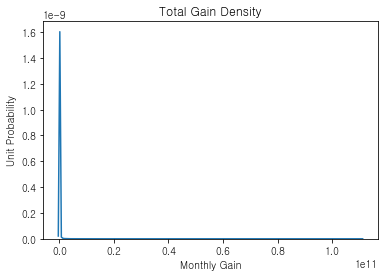

In [14]:
ax = plt.subplots()
ax = sns.distplot(data['monthly_gain'], hist=False)
ax.set_title('Total Gain Density')
ax.set_xlabel('Monthly Gain')
ax.set_ylabel('Unit Probability')

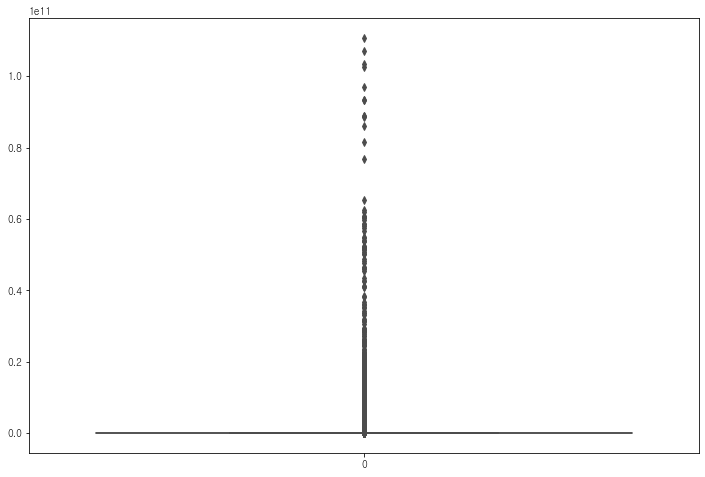

In [16]:
plt.figure(figsize=(12,8))
sns.boxplot(data=data['monthly_gain'], color='red')
plt.show()

# Preprocessing
- shop_code, shop_name : 식별자 feature 이므로 drop 
- shop_type_big, shop_type_small : label encodding, 혹은..?
- longitude, latitude : 일단은 input_feature에 넣지만 중복값이 많아 보이므로 추후에 제거한 것도 실험해보아야 함 
- monthly_gain : 결측치 제거 (0값, 3605개로 계산됨)
- date : drop, 그러나 RNN, LSTM과 같은 DL 모델에서는 넣어야 할 수 도 있다 -> 이 경우는 data를 다른 시각으로 접근해보아야 함, 시계열이기 때문
- MinMaxSaclar 정규화도 해야할까?

In [80]:
# 원본 data와 따로 관리 -> original data = data, input data = input_data 
# feature drop
input_data = data.copy()

input_data = input_data.drop(['date', 'shop_code', 'shop_name'], axis=1)
input_data

,shop_type_big,shop_type_small,longitude,latitude,monthly_gain,average_sale_price,female_20,female_30,female_40,female_50,...,weekday4,weekday5,weekday6,time_05_10,time_10_14,time_14_18,time_18_20,time_20_22,time_22_24,time_00_05
0,음식,카페 일반,126.927911,37.558043,5.696400e+06,9982,9.58,5.43,18.68,4.63,...,17.15,11.92,6.34,1.15,72.78,23.14,2.93,0.00,0.00,0.00
1,음식,한정식/백반 전문점,127.022532,37.506856,8.496120e+06,14503,5.08,12.12,9.68,8.15,...,19.38,16.35,10.82,0.83,76.82,13.25,9.09,0.00,0.00,0.00
2,음식,고기구이 전문점,127.025013,37.505696,1.036515e+08,72527,10.51,9.64,4.05,3.57,...,21.18,21.59,18.04,4.64,8.50,2.40,18.67,50.05,9.84,5.89
3,음식,고기구이 전문점,127.025013,37.505696,9.678575e+07,70225,12.10,11.48,6.31,4.77,...,26.08,22.60,15.51,2.68,8.09,5.77,10.15,54.61,16.25,2.45
4,소매,스포츠용품 판매,126.903306,37.517063,1.266359e+08,91884,15.04,10.48,16.90,9.56,...,16.44,10.38,22.71,0.43,26.38,39.20,25.30,8.69,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153390,학문/교육,학원-기타,127.040033,37.525081,2.277527e+07,1114250,0.00,0.00,25.35,22.82,...,26.48,0.00,0.00,73.52,26.48,0.00,0.00,0.00,0.00,0.00
153391,소매,화장품 판매,127.046604,37.524470,1.555300e+06,33556,0.00,0.00,46.48,44.72,...,5.30,23.18,20.53,23.18,52.65,13.58,10.60,0.00,0.00,0.00
153392,소매,장난감/오락기기/용품 판매,127.060835,37.509203,3.134106e+08,39543,31.27,14.62,9.13,2.91,...,13.02,13.71,13.84,6.60,44.94,36.45,12.01,0.00,0.00,0.00
153393,의료,약국,127.103491,37.513101,7.927725e+07,9874,23.15,18.09,9.60,9.93,...,10.42,11.71,16.84,4.45,25.70,30.00,22.70,16.61,0.55,0.00


In [81]:
# LabelEncoder
from sklearn.preprocessing import LabelEncoder

lencoder = LabelEncoder()

item_big = input_data['shop_type_big'].unique()
lencoder.fit(item_big)
input_data['shop_type_big'] = lencoder.transform(input_data['shop_type_big'])

item_small = input_data['shop_type_small'].unique() 
lencoder.fit(item_small)
input_data['shop_type_small'] = lencoder.transform(input_data['shop_type_small'])

input_data

,shop_type_big,shop_type_small,longitude,latitude,monthly_gain,average_sale_price,female_20,female_30,female_40,female_50,...,weekday4,weekday5,weekday6,time_05_10,time_10_14,time_14_18,time_18_20,time_20_22,time_22_24,time_00_05
0,8,308,126.927911,37.558043,5.696400e+06,9982,9.58,5.43,18.68,4.63,...,17.15,11.92,6.34,1.15,72.78,23.14,2.93,0.00,0.00,0.00
1,8,350,127.022532,37.506856,8.496120e+06,14503,5.08,12.12,9.68,8.15,...,19.38,16.35,10.82,0.83,76.82,13.25,9.09,0.00,0.00,0.00
2,8,17,127.025013,37.505696,1.036515e+08,72527,10.51,9.64,4.05,3.57,...,21.18,21.59,18.04,4.64,8.50,2.40,18.67,50.05,9.84,5.89
3,8,17,127.025013,37.505696,9.678575e+07,70225,12.10,11.48,6.31,4.77,...,26.08,22.60,15.51,2.68,8.09,5.77,10.15,54.61,16.25,2.45
4,5,173,126.903306,37.517063,1.266359e+08,91884,15.04,10.48,16.90,9.56,...,16.44,10.38,22.71,0.43,26.38,39.20,25.30,8.69,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153390,13,327,127.040033,37.525081,2.277527e+07,1114250,0.00,0.00,25.35,22.82,...,26.48,0.00,0.00,73.52,26.48,0.00,0.00,0.00,0.00,0.00
153391,5,361,127.046604,37.524470,1.555300e+06,33556,0.00,0.00,46.48,44.72,...,5.30,23.18,20.53,23.18,52.65,13.58,10.60,0.00,0.00,0.00
153392,5,261,127.060835,37.509203,3.134106e+08,39543,31.27,14.62,9.13,2.91,...,13.02,13.71,13.84,6.60,44.94,36.45,12.01,0.00,0.00,0.00
153393,10,193,127.103491,37.513101,7.927725e+07,9874,23.15,18.09,9.60,9.93,...,10.42,11.71,16.84,4.45,25.70,30.00,22.70,16.61,0.55,0.00


In [82]:
input_data['shop_type_big'].value_counts()

8     51202
5     49197
10    16774
4     16698
13     4739
14     4468
0      3706
2      2738
7      1614
6      1236
12      545
3       345
11      103
1        23
9         7
Name: shop_type_big, dtype: int64

In [83]:
# 결측치 제거 
drop_index = input_data[input_data['monthly_gain']==0].index 
input_data = input_data.drop(drop_index)
input_data

,shop_type_big,shop_type_small,longitude,latitude,monthly_gain,average_sale_price,female_20,female_30,female_40,female_50,...,weekday4,weekday5,weekday6,time_05_10,time_10_14,time_14_18,time_18_20,time_20_22,time_22_24,time_00_05
0,8,308,126.927911,37.558043,5.696400e+06,9982,9.58,5.43,18.68,4.63,...,17.15,11.92,6.34,1.15,72.78,23.14,2.93,0.00,0.00,0.00
1,8,350,127.022532,37.506856,8.496120e+06,14503,5.08,12.12,9.68,8.15,...,19.38,16.35,10.82,0.83,76.82,13.25,9.09,0.00,0.00,0.00
2,8,17,127.025013,37.505696,1.036515e+08,72527,10.51,9.64,4.05,3.57,...,21.18,21.59,18.04,4.64,8.50,2.40,18.67,50.05,9.84,5.89
3,8,17,127.025013,37.505696,9.678575e+07,70225,12.10,11.48,6.31,4.77,...,26.08,22.60,15.51,2.68,8.09,5.77,10.15,54.61,16.25,2.45
4,5,173,126.903306,37.517063,1.266359e+08,91884,15.04,10.48,16.90,9.56,...,16.44,10.38,22.71,0.43,26.38,39.20,25.30,8.69,0.00,0.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153390,13,327,127.040033,37.525081,2.277527e+07,1114250,0.00,0.00,25.35,22.82,...,26.48,0.00,0.00,73.52,26.48,0.00,0.00,0.00,0.00,0.00
153391,5,361,127.046604,37.524470,1.555300e+06,33556,0.00,0.00,46.48,44.72,...,5.30,23.18,20.53,23.18,52.65,13.58,10.60,0.00,0.00,0.00
153392,5,261,127.060835,37.509203,3.134106e+08,39543,31.27,14.62,9.13,2.91,...,13.02,13.71,13.84,6.60,44.94,36.45,12.01,0.00,0.00,0.00
153393,10,193,127.103491,37.513101,7.927725e+07,9874,23.15,18.09,9.60,9.93,...,10.42,11.71,16.84,4.45,25.70,30.00,22.70,16.61,0.55,0.00


In [96]:
# 정규화
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scale_cols = input_data.columns.tolist()
scaled_data = scaler.fit_transform(input_data[scale_cols])
scaled_data = pd.DataFrame(scaled_data)
scaled_data.columns = scale_cols 

input_data = scaled_data
input_data

,shop_type_big,shop_type_small,longitude,latitude,monthly_gain,average_sale_price,female_20,female_30,female_40,female_50,...,weekday4,weekday5,weekday6,time_05_10,time_10_14,time_14_18,time_18_20,time_20_22,time_22_24,time_00_05
0,0.571429,0.839237,0.128587,0.843021,0.000051,0.000121,0.0958,0.0543,0.1868,0.046295,...,0.1715,0.1192,0.0634,0.0115,0.7278,0.2314,0.0293,0.0000,0.0000,0.0000
1,0.571429,0.953678,0.598197,0.143170,0.000077,0.000176,0.0508,0.1212,0.0968,0.081492,...,0.1938,0.1635,0.1082,0.0083,0.7682,0.1325,0.0909,0.0000,0.0000,0.0000
2,0.571429,0.046322,0.610510,0.127312,0.000936,0.000881,0.1051,0.0964,0.0405,0.035696,...,0.2118,0.2159,0.1804,0.0464,0.0850,0.0240,0.1867,0.5005,0.0984,0.0589
3,0.571429,0.046322,0.610510,0.127312,0.000874,0.000853,0.1210,0.1148,0.0631,0.047695,...,0.2608,0.2260,0.1551,0.0268,0.0809,0.0577,0.1015,0.5461,0.1625,0.0245
4,0.357143,0.471390,0.006469,0.282728,0.001143,0.001116,0.1504,0.1048,0.1690,0.095590,...,0.1644,0.1038,0.2271,0.0043,0.2638,0.3920,0.2530,0.0869,0.0000,0.0000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
149785,0.928571,0.891008,0.685052,0.392348,0.000206,0.013529,0.0000,0.0000,0.2535,0.228177,...,0.2648,0.0000,0.0000,0.7352,0.2648,0.0000,0.0000,0.0000,0.0000,0.0000
149786,0.357143,0.983651,0.717663,0.383997,0.000014,0.000407,0.0000,0.0000,0.4648,0.447155,...,0.0530,0.2318,0.2053,0.2318,0.5265,0.1358,0.1060,0.0000,0.0000,0.0000
149787,0.357143,0.711172,0.788293,0.175261,0.002829,0.000480,0.3127,0.1462,0.0913,0.029097,...,0.1302,0.1371,0.1384,0.0660,0.4494,0.3645,0.1201,0.0000,0.0000,0.0000
149788,0.714286,0.525886,1.000000,0.228566,0.000716,0.000120,0.2315,0.1809,0.0960,0.099290,...,0.1042,0.1171,0.1684,0.0445,0.2570,0.3000,0.2270,0.1661,0.0055,0.0000


C:\Users\Hyeongbin\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


0.000005    57
0.000005    54
0.000002    54
0.000001    48
0.000001    48
            ..
0.000010     1
0.001389     1
0.000019     1
0.000027     1
0.020699     1
Name: monthly_gain, Length: 114881, dtype: int64


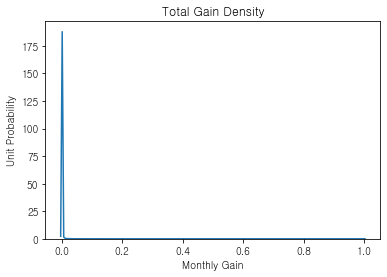

In [97]:
ax = plt.subplots()
ax = sns.distplot(input_data['monthly_gain'], hist=False)
ax.set_title('Total Gain Density')
ax.set_xlabel('Monthly Gain')
ax.set_ylabel('Unit Probability')
print(input_data['monthly_gain'].value_counts())

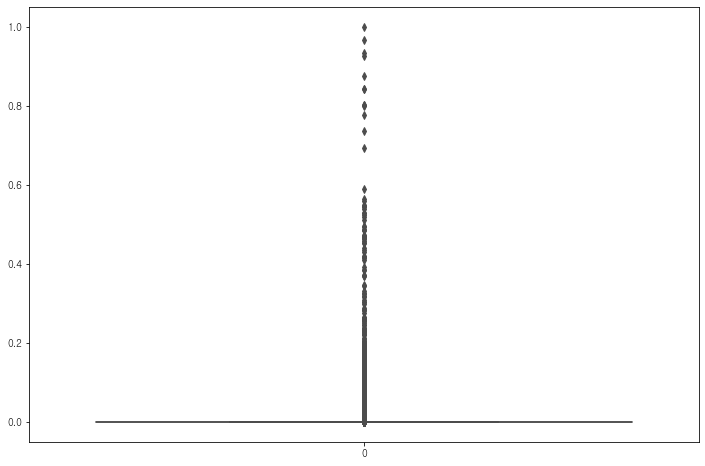

In [98]:
plt.figure(figsize=(12,8))
sns.boxplot(data=input_data['monthly_gain'], color='red')
plt.show()

# Data Split

In [99]:
input_data_y = input_data['monthly_gain'].copy()
input_data_X = input_data.drop(['monthly_gain'], axis=1)

In [100]:
from sklearn.model_selection import train_test_split

tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2,      
    shuffle=True,         
    random_state=42)      

train_X, valid_X, train_y, valid_y = train_test_split(
    tr_val_X, 
    tr_val_y, 
    test_size = 0.2,      
    shuffle=True,         
    random_state=42)   

# Modeling
- XGB
- LGBM

In [101]:
from sklearn.model_selection import train_test_split, cross_val_score, KFold, TimeSeriesSplit,GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression

from lightgbm import LGBMRegressor
from lightgbm import plot_importance 
from xgboost import XGBRegressor
from xgboost import plot_importance
import xgboost as xgb

#import pathlib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from keras import backend as K
from tensorflow.keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ModelCheckpoint

In [102]:
model_xgb = XGBRegressor(n_estimators=1000, learning_rate=0.05)

evals = [(valid_X, valid_y)]
model_xgb.fit(train_X, train_y, early_stopping_rounds=100, eval_metric="logloss", eval_set=evals,verbose=True)

[0]	validation_0-logloss:0.64453
[1]	validation_0-logloss:0.60043
[2]	validation_0-logloss:0.56028
[3]	validation_0-logloss:0.52358
[4]	validation_0-logloss:0.48991
[5]	validation_0-logloss:0.45896
[6]	validation_0-logloss:0.43043
[7]	validation_0-logloss:0.40405
[8]	validation_0-logloss:0.37964
[9]	validation_0-logloss:0.35698
[10]	validation_0-logloss:0.33593
[11]	validation_0-logloss:0.31631
[12]	validation_0-logloss:0.29804
[13]	validation_0-logloss:0.28098
[14]	validation_0-logloss:0.26504
[15]	validation_0-logloss:0.25012
[16]	validation_0-logloss:0.23617
[17]	validation_0-logloss:0.22309
[18]	validation_0-logloss:0.21082
[19]	validation_0-logloss:0.19931
[20]	validation_0-logloss:0.18849
[21]	validation_0-logloss:0.17833
[22]	validation_0-logloss:0.16877
[23]	validation_0-logloss:0.15977
[24]	validation_0-logloss:0.15130
[25]	validation_0-logloss:0.14332
[26]	validation_0-logloss:0.13580
[27]	validation_0-logloss:0.12871
[28]	validation_0-logloss:0.12201
[29]	validation_0-loglos

[238]	validation_0-logloss:0.00464
[239]	validation_0-logloss:0.00464
[240]	validation_0-logloss:0.00464
[241]	validation_0-logloss:0.00464
[242]	validation_0-logloss:0.00464
[243]	validation_0-logloss:0.00464
[244]	validation_0-logloss:0.00464
[245]	validation_0-logloss:0.00464
[246]	validation_0-logloss:0.00464
[247]	validation_0-logloss:0.00465
[248]	validation_0-logloss:0.00465
[249]	validation_0-logloss:0.00465
[250]	validation_0-logloss:0.00465
[251]	validation_0-logloss:0.00464
[252]	validation_0-logloss:0.00464
[253]	validation_0-logloss:0.00464
[254]	validation_0-logloss:0.00464
[255]	validation_0-logloss:0.00465
[256]	validation_0-logloss:0.00465


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.05, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=1000, n_jobs=6, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [103]:
pred_xgb = model_xgb.predict(test_X)

## Prediction

In [119]:
def plot_history(history):
    #hist = pd.DataFrame(history.history)
    #history['epoch'] = history.epoch
    
    plt.figure(figsize=(8,12))
    
    # Mean Abs Error : 평균 절대 오차, 측정값에서 오차의 크기로 측정값과 실제값과의 차이, 절대 오차의 평균  
    # -> 측정하고자 하는 값을 정확하게 측정하지 못함으로써 발생
    plt.subplot(2,1,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error')
    plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
    plt.legend()
    
    # Mean Square Error : 평균 제곱 오차, 오차의 제복에 대한 평균을 취한 값
    plt.subplot(2,1,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error')
    plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
    plt.legend()
    plt.show()
    
def show_pred(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    
    df_result = pd.DataFrame(list(zip(true_y, pred)), columns=['true_y', 'prediction'])
    return df_result

def show_mse_rmse(test_y, pred) :
    mse = mean_squared_error(test_y, pred)
    print("mse : %f" % mse)
    
    rmse = np.sqrt(mse)
    print("rmse: %f \n" %rmse)
    
def show_prediction_error(test_y, pred) :
    true_y = test_y.to_numpy()
    true_y = np.ravel(true_y)
    error = pred - true_y
    plt.hist(error, bins=50)
    plt.xlabel("Prediction Error")
    _ = plt.ylabel("Count")
    
def feature_importance(model_xgb) : 
    %matplotlib inline
    plt.rcParams['axes.unicode_minus'] = False
    font_path = "C:/Windows/Fonts/NGULIM.TTF"
    font = fm.FontProperties(fname=font_path).get_name()
    rc('font', family=font)

    fig, ax = plt.subplots(figsize=(10,12))
    plot_importance(model_xgb, ax=ax)
    
def graph(pred, test_label) :
    plt.figure(figsize=(16, 9))
    plt.plot(test_label, label = 'actual')
    plt.plot(pred, label = 'prediction')
    plt.legend()
    plt.show()

In [109]:
show_pred(test_y, pred_xgb)

,true_y,prediction
0,0.000429,0.000493
1,0.000025,0.000386
2,0.000014,0.000101
3,0.000004,0.000127
4,0.000005,0.000047
...,...,...
29953,0.000032,0.000139
29954,0.000072,0.000385
29955,0.000476,0.000262
29956,0.000356,0.000570


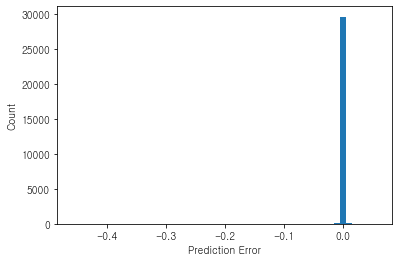

In [110]:
show_prediction_error(test_y, pred_xgb)

In [111]:
show_mse_rmse(test_y, pred_xgb)

mse : 0.000018
rmse: 0.004276 



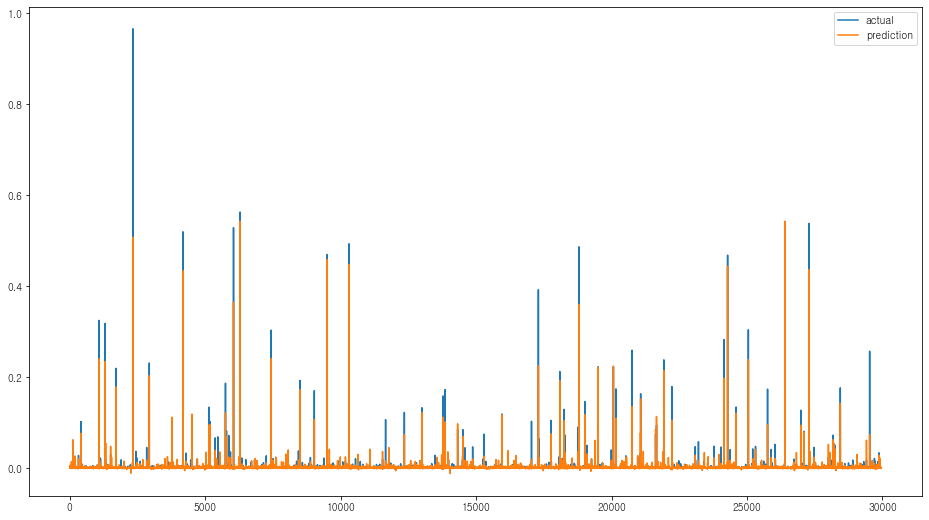

In [114]:
true_y = test_y.to_numpy()
graph(pred_xgb, true_y)

<AxesSubplot:>

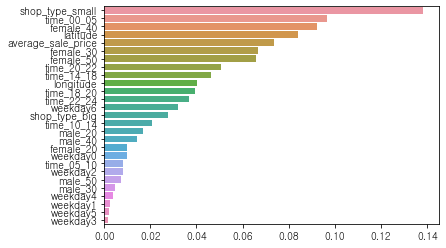

In [115]:
feature_series = pd.Series(data=model_xgb.feature_importances_, index=train_X.columns)
feature_series = feature_series.sort_values(ascending=False) 
sns.barplot(x = feature_series, y=feature_series.index)

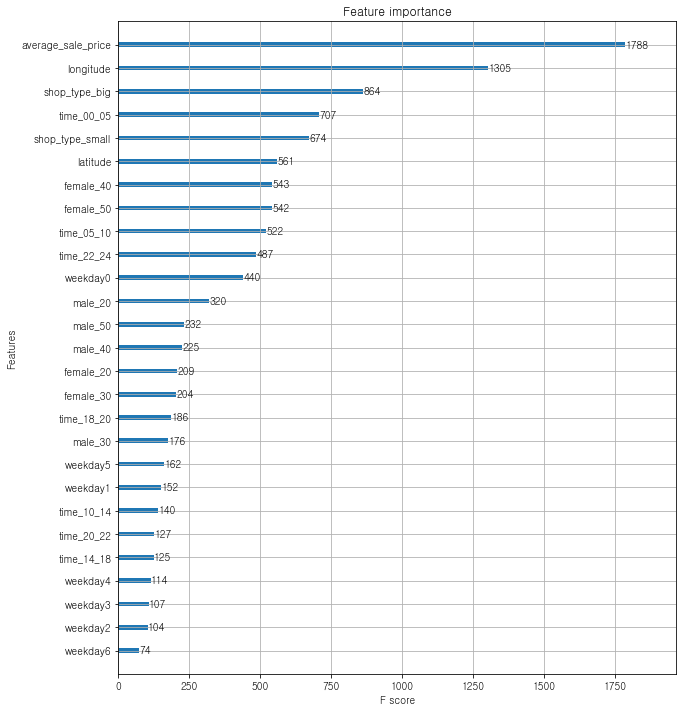

In [118]:
feature_importance(model_xgb)